# Post-Training Quantization and Weights Compression of OpenAI BLIP model with NNCF

The goal of this tutorial is to demonstrate how to speed up the model by applying 8-bit post-training quantization and data free int8 weight compression from [NNCF](https://github.com/openvinotoolkit/nncf/) (Neural Network Compression Framework) to OpenVINO IR models and infer optimized BLIP model via OpenVINO™ Toolkit. The optimization process contains the following steps:

1. Download and preprocess dataset for quantization.
2. Quantize the converted vision and text encoder OpenVINO models from [notebook](233-blip-convert.ipynb) with NNCF.
3. Compress weights of the OpenVINO text decoder model from [notebook](233-blip-convert.ipynb) with NNCF.
4. Check the model result using the same input data from the [notebook](233-blip-convert.ipynb).
5. Compare model size of converted and optimized models.
6. Compare performance of converted and optimized models.

> **NOTE**: you should run [233-blip-convert](233-blip-convert.ipynb) notebook first to generate OpenVINO IR models that are used for optimization.

#### Table of contents:
- [Prerequisites](#Prerequisites)
- [Quantize](#Quantize)
    - [Prepare dataset](#Prepare-dataset)
    - [Vision model](#Vision-model)
    - [Text encoder](#Text-encoder)
- [Compress weights](#Compress-weights)
- [Run optimized OpenVINO model](#Run-optimized-OpenVINO-model)
    - [Image Captioning](#Image-Captioning)
    - [Question Answering](#Question-Answering)
    - [Compare file sizes](#Compare-file-sizes)
    - [Compare inference time of the FP16 and optimized models](#Compare-inference-time-of-the-FP16-and-optimized-models)


## Prerequisites
[back to top ⬆️](#Table-of-contents:)


In [ ]:
%pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00


In [ ]:
%pip install openvino
%pip install nncf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path

VISION_MODEL_OV = Path("/content/drive/MyDrive/BLIP_OpenVINO/Optimaize/blip_vision_model.xml")
TEXT_ENCODER_OV = Path("/content/drive/MyDrive/BLIP_OpenVINO/Optimaize/blip_text_encoder.xml")
TEXT_DECODER_OV = Path("/content/drive/MyDrive/BLIP_OpenVINO/Optimaize/blip_text_decoder_with_past.xml")

if not (VISION_MODEL_OV.exists() and TEXT_ENCODER_OV.exists() and TEXT_DECODER_OV.exists()):
    raise RuntimeError('This notebook should be run after 233-blip-convert notebook')

In [ ]:
from transformers import BlipProcessor

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

## Quantize
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding the quantization layers into the model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. The framework is designed so that modifications to your original training code are minor.

The optimization process contains the following steps:

1. Create a dataset for quantization.
2. Run `nncf.quantize` to get a quantized model from the pre-trained `FP16` model.
3. Serialize the `INT8` model using `openvino.save_model` function.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

### Prepare dataset
[back to top ⬆️](#Table-of-contents:)


The [`VQAv2`](https://visualqa.org/) is a dataset containing open-ended questions about images. These questions require an understanding of vision, language and commonsense knowledge to answer.

In [ ]:
import numpy as np
from datasets import load_dataset
from tqdm.notebook import tqdm

def preprocess_batch(batch, vision_model, inputs_info):
    """
    Preprocesses a dataset batch by loading and transforming image and text data.
    VQAv2 dataset contains multiple questions to image.
    To reduce dataset preparation time we will store preprocessed images in `inputs_info`.
    """
    image_id = batch["image_id"]
    if image_id in inputs_info:
        inputs = processor(text=batch['question'], return_tensors="np")
        pixel_values = inputs_info[image_id]["pixel_values"]
        encoder_hidden_states = inputs_info[image_id]["encoder_hidden_states"]
    else:
        inputs = processor(images=batch["image"], text=batch["question"], return_tensors="np")
        pixel_values = inputs["pixel_values"]
        encoder_hidden_states = vision_model(pixel_values)[vision_model.output(0)]
        inputs_info[image_id] = {
            "pixel_values": pixel_values,
            "encoder_hidden_states": encoder_hidden_states,
            "text_encoder_inputs": []
        }

    text_encoder_inputs = {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"]
    }
    inputs_info[image_id]["text_encoder_inputs"].append(text_encoder_inputs)


def prepare_input_data(dataloader, vision_model, opt_init_steps):
    """
    Store calibration subset in List to reduce quantization time.
    """
    inputs_info = {}
    for batch in tqdm(dataloader, total=opt_init_steps, desc="Prepare calibration data"):
        preprocess_batch(batch, vision_model, inputs_info)

    calibration_subset = []
    for image_id in inputs_info:
        pixel_values = inputs_info[image_id]["pixel_values"]
        encoder_hidden_states = inputs_info[image_id]["encoder_hidden_states"]
        encoder_attention_mask = np.ones(encoder_hidden_states.shape[:-1], dtype=int)
        for text_encoder_inputs in inputs_info[image_id]["text_encoder_inputs"]:
            text_encoder_inputs["encoder_hidden_states"] = encoder_hidden_states
            text_encoder_inputs["encoder_attention_mask"] = encoder_attention_mask
            blip_inputs = {
                "vision_model_inputs": {"pixel_values": pixel_values},
                "text_encoder_inputs": text_encoder_inputs,
            }
            calibration_subset.append(blip_inputs)
    return calibration_subset


def prepare_dataset(vision_model, opt_init_steps=300, streaming=True):
    """
    Prepares a vision-text dataset for quantization.
    """
    dataset = load_dataset("HuggingFaceM4/VQAv2", split="train", streaming=streaming)
    train_dataset = dataset.shuffle(seed=42).take(opt_init_steps)
    calibration_subset = prepare_input_data(train_dataset, vision_model, opt_init_steps)
    return calibration_subset

Loading and processing the dataset in streaming mode may take a long time and depends on your internet connection.

In [ ]:
import nncf
import openvino as ov

comp_vision_model = ov.compile_model(VISION_MODEL_OV)
calibration_data = prepare_dataset(comp_vision_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Prepare calibration data:   0%|          | 0/300 [00:00<?, ?it/s]

### Vision model
[back to top ⬆️](#Table-of-contents:)


In [ ]:
VISION_MODEL_OV_INT8 = Path(str(VISION_MODEL_OV).replace(".xml", "_int8.xml"))

core = ov.Core()
ov_vision_model = core.read_model(VISION_MODEL_OV)
vision_dataset = nncf.Dataset(calibration_data, lambda x: x["vision_model_inputs"])

quantized_model = nncf.quantize(
    model=ov_vision_model,
    calibration_dataset=vision_dataset,
    model_type=nncf.ModelType.TRANSFORMER
)

ov.save_model(quantized_model, VISION_MODEL_OV_INT8)

Output()

Output()

INFO:nncf:36 ignored nodes were found by name in the NNCFGraph


Output()

Output()

### Text encoder
[back to top ⬆️](#Table-of-contents:)


In [ ]:
TEXT_ENCODER_OV_INT8 = Path(str(TEXT_ENCODER_OV).replace(".xml", "_int8.xml"))

text_encoder_dataset = nncf.Dataset(calibration_data, lambda x: x["text_encoder_inputs"])
ov_text_encoder = core.read_model(TEXT_ENCODER_OV)
quantized_model = nncf.quantize(
    model=ov_text_encoder,
    calibration_dataset=text_encoder_dataset,
    model_type=nncf.ModelType.TRANSFORMER
)
ov.save_model(quantized_model, TEXT_ENCODER_OV_INT8)

Output()

Output()

INFO:nncf:72 ignored nodes were found by name in the NNCFGraph


Output()

Output()

## Compress weights
[back to top ⬆️](#Table-of-contents:)

The quantization of the text decoder leads to significant accuracy loss.
Instead of post-training quantization, we can use data free weights compression to reduce the model footprint.

The optimization process contains the following steps:

1. Run `nncf.compress_weights` to get a model with compressed weights.
2. Serialize the `OpenVINO` model using `openvino.save_model` function.

In [ ]:
TEXT_DECODER_OV_INT8 = Path(str(TEXT_DECODER_OV).replace(".xml", "_int8.xml"))

text_decoder = core.read_model(TEXT_DECODER_OV)
compressed_text_decoder = nncf.compress_weights(text_decoder)
ov.save_model(compressed_text_decoder, str(TEXT_DECODER_OV_INT8))

INFO:nncf:Statistics of the bitwidth distribution:
+--------------+------------------+--------------------+
| Num bits (N) |   % all weight   | % internal weights |
+==============+==================+====================+
| 8            | 100% (123 / 123) | 100% (121 / 121)   |
+--------------+------------------+--------------------+


Output()

In [ ]:
import sys

sys.path.append("/content/drive/MyDrive/BLIP_OpenVINO")
# # Now try importing the modules
from utils import *
from notebook_utils import *
from blip_model import *

## Run optimized OpenVINO model
[back to top ⬆️](#Table-of-contents:)

The steps for making predictions with the optimized OpenVINO BLIP model are similar to the PyTorch model. Let us check the model result using the same input data from the [first notebook](233-blip-convert.ipynb).

In [ ]:
q_ov_vision_model = ov.compile_model(VISION_MODEL_OV_INT8)
q_ov_text_encoder = ov.compile_model(TEXT_ENCODER_OV_INT8)
q_ov_text_decoder_with_past = ov.compile_model(TEXT_DECODER_OV_INT8)

In [ ]:
from functools import partial
from transformers import BlipForQuestionAnswering
from blip_model import OVBlipModel, text_decoder_forward

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
text_decoder = model.text_decoder
text_decoder.eval()

text_decoder.forward = partial(text_decoder_forward, ov_text_decoder_with_past=q_ov_text_decoder_with_past)
int8_model = OVBlipModel(model.config, model.decoder_start_token_id, q_ov_vision_model, q_ov_text_encoder, text_decoder)

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [ ]:
from PIL import Image
# raw_image = Image.open("demo.jpg").convert('RGB')

raw_image = Image.open("/content/drive/MyDrive/BLIP_OpenVINO/Optimaize/demo.jpg").convert('RGB')
question = "how many dogs are in the picture?"
# preprocess input data
inputs = processor(raw_image, question, return_tensors="pt")

### Image Captioning
[back to top ⬆️](#Table-of-contents:)


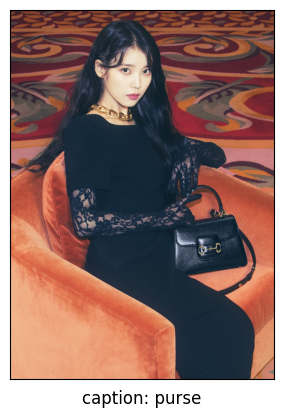

In [ ]:
from utils import visualize_results

out = int8_model.generate_caption(inputs["pixel_values"], max_length=20)
caption = processor.decode(out[0], skip_special_tokens=True)
fig = visualize_results(raw_image, caption)

### Question Answering
[back to top ⬆️](#Table-of-contents:)


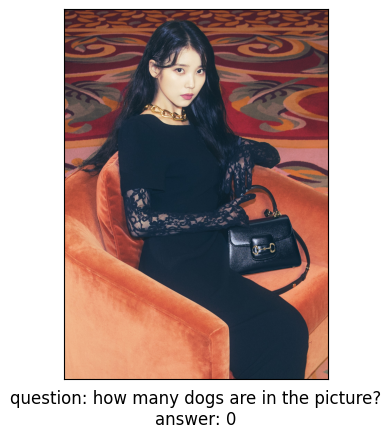

In [ ]:
out = int8_model.generate_answer(**inputs, max_length=20)
answer = processor.decode(out[0], skip_special_tokens=True)
fig = visualize_results(raw_image, answer, question)

### Compare file sizes
[back to top ⬆️](#Table-of-contents:)


In [ ]:
def calculate_compression_rate(ov_model_path):
    fp16_ir_model_size = Path(ov_model_path).with_suffix(".bin").stat().st_size / 1024
    int8_model_path = str(ov_model_path).replace(".xml", "_int8.xml")
    quantized_model_size = Path(int8_model_path).with_suffix(".bin").stat().st_size / 1024
    print(f'{ov_model_path.as_posix().split(".")[0]}')
    print(f"    * FP16 IR model size: {fp16_ir_model_size:.2f} KB")
    print(f"    * INT8 model size: {quantized_model_size:.2f} KB")
    print(f"    * Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

In [ ]:
for model_path in [VISION_MODEL_OV, TEXT_ENCODER_OV, TEXT_DECODER_OV]:
    calculate_compression_rate(model_path)

/content/drive/MyDrive/BLIP_OpenVINO/Optimaize/blip_vision_model
    * FP16 IR model size: 168148.73 KB
    * INT8 model size: 84915.78 KB
    * Model compression rate: 1.980
/content/drive/MyDrive/BLIP_OpenVINO/Optimaize/blip_text_encoder
    * FP16 IR model size: 268087.21 KB
    * INT8 model size: 134677.22 KB
    * Model compression rate: 1.991
/content/drive/MyDrive/BLIP_OpenVINO/Optimaize/blip_text_decoder_with_past
    * FP16 IR model size: 269303.40 KB
    * INT8 model size: 135293.53 KB
    * Model compression rate: 1.991


### Compare inference time of the FP16 and optimized models
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of the `FP16` and `INT8` models, we use median inference time on 100 samples of the calibration dataset.
So we can approximately estimate the speed up of the dynamic quantized models.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications with static shapes.

In [ ]:
import time
import torch

def calculate_inference_time(blip_model, calibration_data, generate_caption):
    inference_time = []
    for inputs in calibration_data:
        pixel_values = torch.from_numpy(inputs["vision_model_inputs"]["pixel_values"])
        input_ids = torch.from_numpy(inputs["text_encoder_inputs"]["input_ids"])
        attention_mask = torch.from_numpy(inputs["text_encoder_inputs"]["attention_mask"])

        start = time.perf_counter()
        if generate_caption:
            _ = blip_model.generate_caption(pixel_values, max_length=20)
        else:
            _ = blip_model.generate_answer(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask, max_length=20)
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
    return np.median(inference_time)

In [ ]:
fp_original_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
fp_text_decoder = fp_original_model.text_decoder
fp_text_decoder.eval()

comp_text_encoder = ov.compile_model(TEXT_ENCODER_OV)
comp_text_decoder_with_past = ov.compile_model(TEXT_DECODER_OV)
fp_text_decoder.forward = partial(text_decoder_forward, ov_text_decoder_with_past=comp_text_decoder_with_past)
fp16_model = OVBlipModel(model.config, model.decoder_start_token_id, comp_vision_model, comp_text_encoder, fp_text_decoder)

In [ ]:
validation_data = calibration_data[:100]

int8_caption_latency = calculate_inference_time(int8_model, validation_data, generate_caption=True)
fp16_caption_latency = calculate_inference_time(fp16_model, validation_data, generate_caption=True)

print(f"Image Captioning speed up: {fp16_caption_latency / int8_caption_latency:.3f}")

Image Captioning speed up: 1.161


In [ ]:
int8_generate_answer_latency = calculate_inference_time(int8_model, validation_data, generate_caption=False)
fp16_generate_answer_latency = calculate_inference_time(fp16_model, validation_data, generate_caption=False)
print(f"Question Answering speed up: {fp16_generate_answer_latency / int8_generate_answer_latency:.3f}")

Question Answering speed up: 1.451


## 최적화 모델 실행

In [ ]:
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu torch torchvision "transformers>=4.18.0" gradio "openvino>=2022.2.0" matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB

In [ ]:
import openvino as ov
from PIL import Image
import requests
from transformers import BlipProcessor
import ipywidgets as widgets
import time

# BLIP 프로세서 초기화
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

# OpenVINO Core 객체 생성
core = ov.Core()

# 장치 선택을 위한 드롭다운 메뉴
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

# 모델 컴파일
q_ov_vision_model = ov.compile_model("/content/drive/MyDrive/BLIP_OpenVINO/Optimaize0/blip_vision_model_int8.xml", "CPU")
q_ov_text_encoder = ov.compile_model("/content/drive/MyDrive/BLIP_OpenVINO/Optimaize0/blip_text_encoder_int8.xml", "CPU")
q_ov_text_decoder_with_past = ov.compile_model("/content/drive/MyDrive/BLIP_OpenVINO/Optimaize0/blip_text_decoder_with_past_int8.xml", "CPU")



preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
import sys

sys.path.append("/content/drive/MyDrive/BLIP_OpenVINO")
# # Now try importing the modules
from utils import *
from notebook_utils import *
from blip_model import *

In [ ]:
from functools import partial
from transformers import BlipForQuestionAnswering
from blip_model import OVBlipModel, text_decoder_forward

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
text_decoder = model.text_decoder
text_decoder.eval()

text_decoder.forward = partial(text_decoder_forward, ov_text_decoder_with_past=q_ov_text_decoder_with_past)
int8_model = OVBlipModel(model.config, model.decoder_start_token_id, q_ov_vision_model, q_ov_text_encoder, text_decoder)

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [ ]:

# 모델 설정 및 디코더 시작 토큰 ID 추출
model_config = model.config
decoder_start_token_id = model.config.decoder_start_token_id


In [ ]:
# 모델 헬퍼 클래스 초기화 OpenVINO 모델 들을 OVBlipModel 클래스를 사용하여 통합

ov_model = OVBlipModel(model_config, decoder_start_token_id, q_ov_vision_model, q_ov_text_encoder, q_ov_text_decoder_with_past)


In [ ]:
from PIL import Image


# 이미지 로드 및 전처리
image_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
image = Image.open(requests.get(image_url, stream=True).raw)

# 질문 정의
question = "Is this a photo without the dog?"

# 이미지와 질문 처리
inputs = processor(image, text=question, return_tensors="pt")



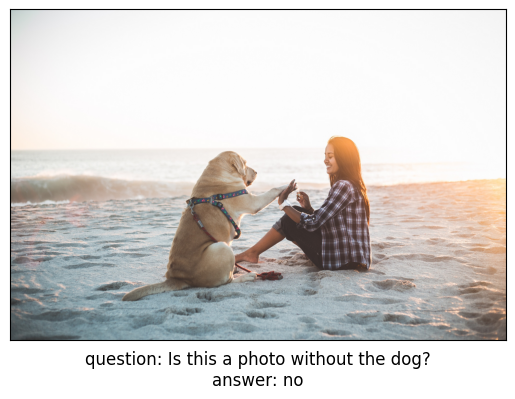

In [ ]:
from transformers import BlipProcessor, BlipForQuestionAnswering
from blip_model import OVBlipModel


# 질문 답변 생성
start = time.perf_counter()
out = int8_model.generate_answer(**inputs, max_length=20)
end = time.perf_counter() - start
answer = processor.decode(out[0], skip_special_tokens=True)

# 결과 시각화
fig = visualize_results(image, answer, question)






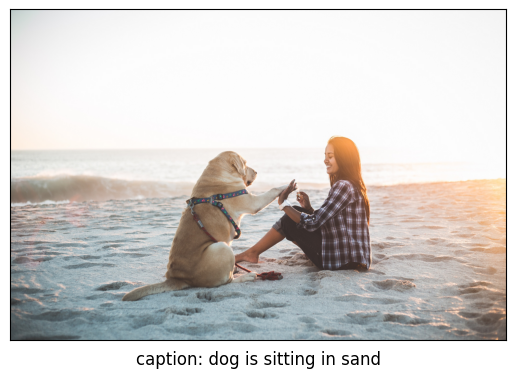

In [ ]:
# 이미지 캡셔닝 생성
out = int8_model.generate_caption(inputs["pixel_values"], max_length=20)
caption = processor.decode(out[0], skip_special_tokens=True)
fig2 = visualize_results(image, caption)
